In [96]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from dateutil.parser import parse

In [3]:
#References 
#https://otexts.org/fpp2/autocorrelation.html
import statsmodels.api as sm 
sm.version.version 

'0.8.0'

In [93]:
data = pd.read_csv('train.csv',low_memory=False)
train_df = pd.read_csv('train.csv' ,parse_dates=['date'],index_col='date')#('../input/train.csv' ,parse_dates=['date'],index_col='date')
train_df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [92]:
test_df = pd.read_csv('test.csv', parse_dates=['date'],index_col='date')#('../input/test.csv', parse_dates=['date'],index_col='date')
total_df = pd.concat([train_df,test_df])#,sort=True)
sample = pd.read_csv('sample_submission.csv')#('../input/sample_submission.csv')

In [98]:
# Very simple Analysis of data by grouping and getting mean of sales
# Present Sales Per Quarter per Store per Item
data['month'] = data['date'].apply(parse, dayfirst=False)
data['quarter'] = pd.PeriodIndex(data['month'],freq='Q')
print('data Grouped by q,s,i',data.groupby(['quarter','store','item'])['sales'].sum())
print('------------------------------------------------------------------------')
print('data Grouped by q,i',data.groupby(['quarter','item'])['sales'].sum())
print('------------------------------------------------------------------------')
print('Sales Mean by ',data.groupby(['item'])['sales'].mean())

data Grouped by q,s,i quarter  store  item
2013Q1   1      1       1127
                2       3083
                3       1933
                4       1153
                5        930
                6       3038
                7       3163
                8       4100
                9       2739
                10      3852
                11      3739
                12      3698
                13      4507
                14      3116
                15      4580
                16      1315
                17      1810
                18      4404
                19      2106
                20      2515
                21      2169
                22      4218
                23      1485
                24      3555
                25      4278
                26      2457
                27      1195
                28      4743
                29      3731
                30      2159
                        ... 
2017Q4   10     21      4377
                22      8644


In [5]:
itemstore = total_df[(total_df.item==1)&(total_df.store==1)].copy()

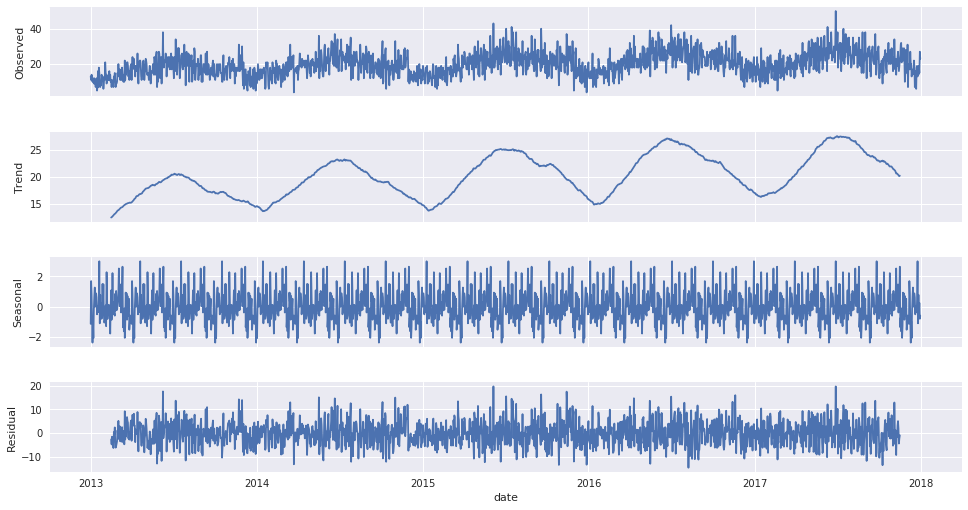

In [6]:
residuals = sm.tsa.seasonal_decompose(itemstore.sales.dropna(),freq=90)
fig = residuals.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()


In [33]:
# I see that the data is seasonal but with a positive trend , and hence not stationary.

In [55]:
#Now let's split the data into train and test
train_store_df = itemstore['2014-01-01':'2017-09-30']
test_store_df = itemstore['2017-10-01':'2017-12-31']
total_store_df = itemstore['2014-01-01':'2017-12-31']
train_store_sales = train_store_df['sales'].dropna()
test_store_sales = test_store_df['sales'].dropna()
total_store_sales = total_store_df['sales'].dropna()

In [9]:
print(train_store_sales.shape)
print(test_store_sales.shape)

(1369,)
(92,)


In [10]:
def test_stationarity(timeseries_df,window):
    roll_mean = timeseries_df.rolling(window).mean()
    roll_std = timeseries_df.rolling(window).std()
    #roll_corr 
    
    #plot stationarity
    fig = plt.figure(figsize= (12,8))
    orig = plt.plot(timeseries_df, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Dickey-Fuller Test:')
    dftest = adfuller(timeseries_df, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < 0.05:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

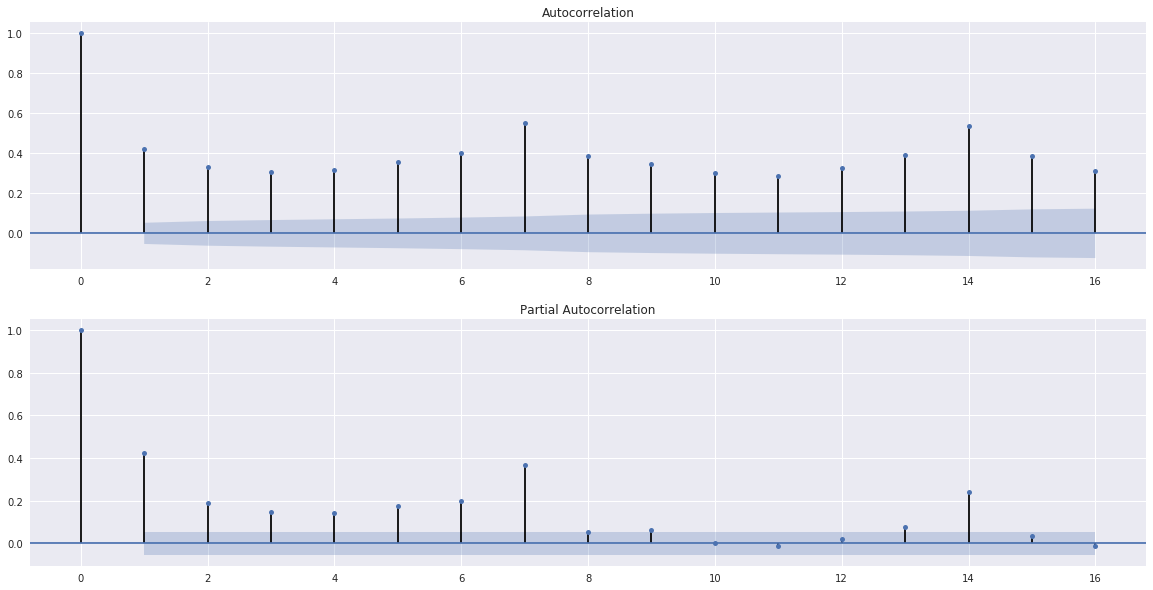

In [11]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train_store_sales.dropna(), lags=16, ax=ax[0],alpha=0.05)
fig = sm.graphics.tsa.plot_pacf(train_store_sales.dropna(), lags=16, ax=ax[1],alpha=0.05)
plt.show()

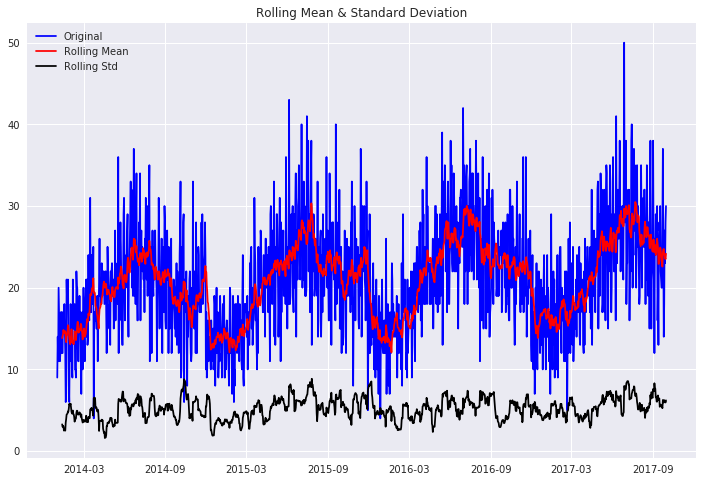

Dickey-Fuller Test:
p-value = 0.1051. The series is likely non-stationary.
Test Statistic                   -2.544169
p-value                           0.105094
#Lags Used                       20.000000
Number of Observations Used    1348.000000
Critical Value (1%)              -3.435210
Critical Value (5%)              -2.863686
Critical Value (10%)             -2.567913
dtype: float64


In [37]:
#Mean is moving up which means the random varaibles are increasing indicating a rising trend. The ACF plot does not show 
#a diminishing trend towards zero indicating the time series is non-stationary. Let's further verify plotting 
#rolling mean
test_stationarity(train_store_sales,12)

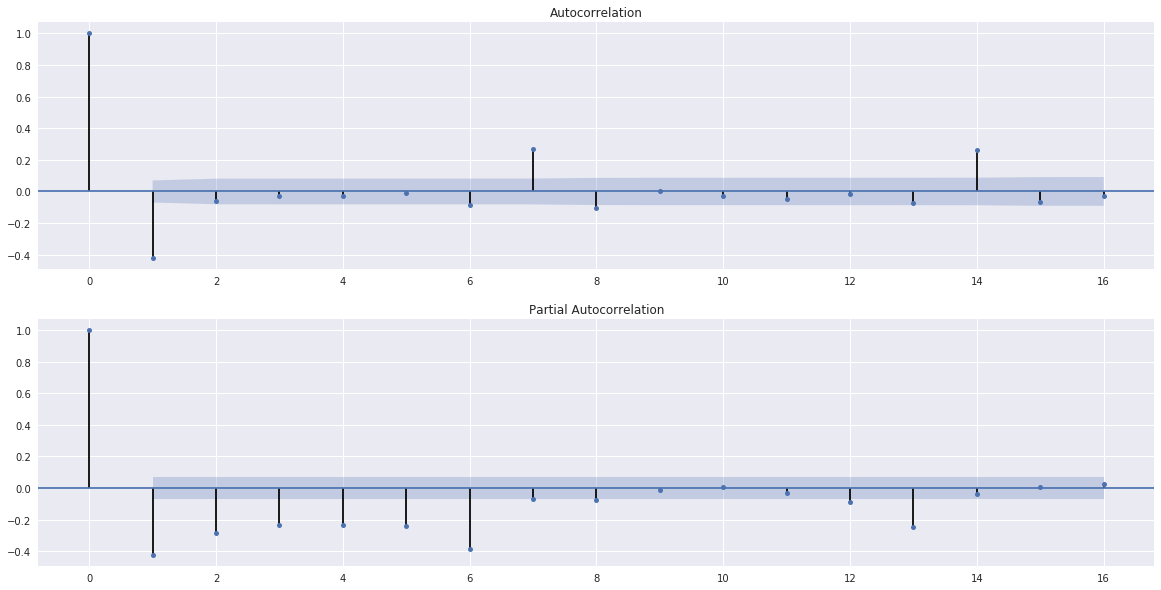

In [12]:
# As we see the original time series is non-statinary, we need to a diff and see if the series becomes staionary.

fig,ax = plt.subplots(2,1,figsize=(20,10))
train_store_sales_diff =train_store_sales.diff().dropna() #diff default is 1, and frequency is day.
fig = sm.graphics.tsa.plot_acf(train_store_sales_diff, lags=16, ax=ax[0],alpha=0.01)
fig = sm.graphics.tsa.plot_pacf(train_store_sales_diff, lags=16, ax=ax[1], alpha=0.01)
plt.show()


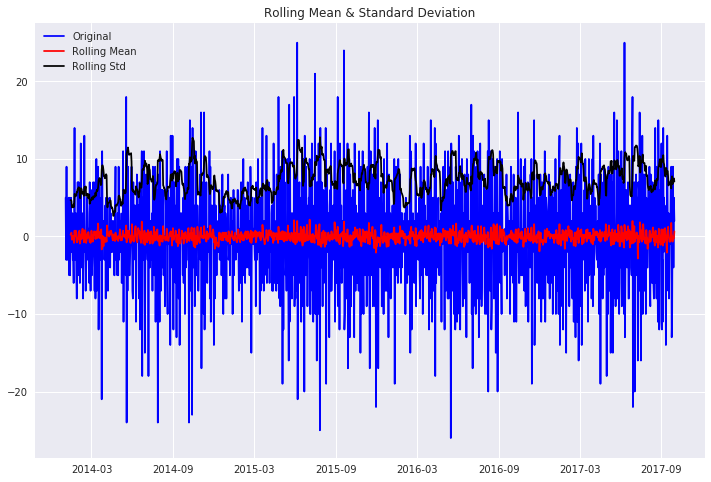

Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.323545e+01
p-value                        9.398967e-25
#Lags Used                     2.000000e+01
Number of Observations Used    1.347000e+03
Critical Value (1%)           -3.435214e+00
Critical Value (5%)           -2.863688e+00
Critical Value (10%)          -2.567914e+00
dtype: float64


In [39]:
# As we can see from ACF plot sales in any Quarter seems to be influenced by Lag1 and Lag7. (so we take p=7, d=1)
# Also given the PACF is not becoming 0 after first lag, there is a MA component, and here we can see the MA for error dies down
#after the 6th lag.
test_stationarity(train_store_sales_diff,12)

In [13]:
#Let's test ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
res_arima = ARIMA(train_store_sales, (6,1,7)).fit(disp=False)
res_arima.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                 1368
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -4086.265
Method:                       css-mle   S.D. of innovations              4.761
Date:                Sat, 29 Sep 2018   AIC                           8202.530
Time:                        13:12:22   BIC                           8280.846
Sample:                    01-02-2014   HQIC                          8231.840
                         - 09-30-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0076      0.012      0.617      0.537      -0.016       0.032
ar.L1.D.sales    -0.9959      0.002   -581.145      0.000      -0.999      -0.992
ar.L2.D.sales    -0.9990      0.002   -408.771      0.000      -1.004      -0.994
ar.L3.D.sales    -0.9977      0.004   -261.641      0.000      -1.005      -0.990
ar.L4.D.sales    -0.9969      0.002   -409.208      0.000      -1.002      -0.992
ar.L5.D.sales    -0.9997      0.002   -458.545      0.000      -1.004      -0.995
ar.L6.D.sales    -0.9950      0.001   -708.386      0.000      -0.998      -0.992
ma.L1.D.sales     0.0817      0.014      5.854      0.000       0.054       0.109
ma.L2.D.sales     0.0987      0.016      6.278      0.000       0.068       0.129
ma.L3.D.sales     0.0698      0.020      3.549      0.000       0.031       0.108
ma.L4.D.sales     0.0810      0.018      4.616      0.000       0.047       0.115
ma.L5.D.sales     0.0994      0.015      6.645      0.000       0.070       0.129
ma.L6.D.sales     0.0919      0.018      5.089      0.000       0.057       0.127
ma.L7.D.sales    -0.8620      0.021    -41.258      0.000      -0.903      -0.821
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6234           -0.7819j            1.0000           -0.1429
AR.2            0.6234           +0.7819j            1.0000            0.1429
AR.3           -0.9032           -0.4350j            1.0025           -0.4286
AR.4           -0.9032           +0.4350j            1.0025            0.4286
AR.5           -0.2226           -0.9749j            1.0000           -0.2857
AR.6           -0.2226           +0.9749j            1.0000            0.2857
MA.1           -0.9099           -0.4408j            1.0110           -0.4282
MA.2           -0.9099           +0.4408j            1.0110            0.4282
MA.3           -0.2228           -0.9772j            1.0023           -0.2857
MA.4           -0.2228           +0.9772j            1.0023            0.2857
MA.5            0.6321           -0.7876j            1.0099           -0.1424
MA.6            0.6321           +0.7876j            1.0099            0.1424
MA.7            1.1077           -0.0000j            1.1077           -0.0000
-----------------------------------------------------------------------------
"""

In [15]:
#Looking at the ACF and PACF graphs for the differencing series, we see AR having correlation with 7(p).  We had to do 1(d) level difference. 
# MA=7 #So p,d,q is (7,1,7)
model_sarimax = sm.tsa.statespace.SARIMAX(train_store_sales,order=(7,1,7),enforce_invertibility=False,enforce_stationarity=False)
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1369
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -4068.474
Date:                Sat, 29 Sep 2018   AIC                           8166.949
Time:                        13:12:51   BIC                           8245.277
Sample:                    01-01-2014   HQIC                          8196.262
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9008      0.036    -24.887      0.000      -0.972      -0.830
ar.L2         -0.9034      0.036    -24.927      0.000      -0.974      -0.832
ar.L3         -0.8984      0.036    -24.816      0.000      -0.969      -0.827
ar.L4         -0.8943      0.036    -24.661      0.000      -0.965      -0.823
ar.L5         -0.8987      0.035    -25.687      0.000      -0.967      -0.830
ar.L6         -0.8949      0.036    -25.037      0.000      -0.965      -0.825
ar.L7          0.0953      0.035      2.726      0.006       0.027       0.164
ma.L1          0.0589      0.021      2.758      0.006       0.017       0.101
ma.L2          0.0936      0.020      4.664      0.000       0.054       0.133
ma.L3          0.0342      0.021      1.657      0.098      -0.006       0.075
ma.L4          0.0552      0.020      2.790      0.005       0.016       0.094
ma.L5          0.0946      0.020      4.830      0.000       0.056       0.133
ma.L6          0.0825      0.021      4.011      0.000       0.042       0.123
ma.L7         -0.8619      0.018    -46.623      0.000      -0.898      -0.826
sigma2        24.6409      0.992     24.843      0.000      22.697      26.585
===================================================================================
Ljung-Box (Q):                       45.06   Jarque-Bera (JB):                10.49
Prob(Q):                              0.27   Prob(JB):                         0.01
Heteroskedasticity (H):               1.35   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

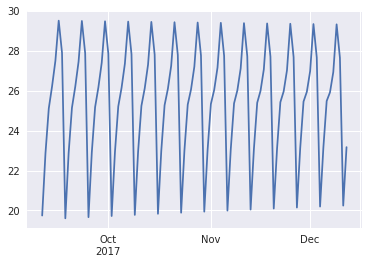

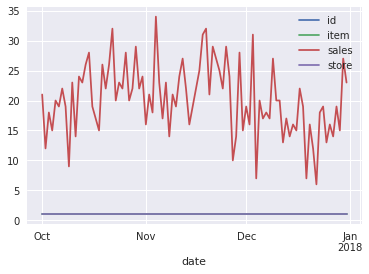

In [65]:
# predict using model.
start_forecast = 1349
end_forecast = 1441 
train_store_sales['forecast'] = results_sarimax.predict(start = start_forecast,end = end_forecast,dynamic=True)
train_store_sales['forecast'].plot.line()
plt.figure(figsize=(10,8))
plt.show()
test_store_df.plot.line()
#train_df_sales[start_loc:end_loc][['sales', 'forecast']].plot(figsize=(12, 8))

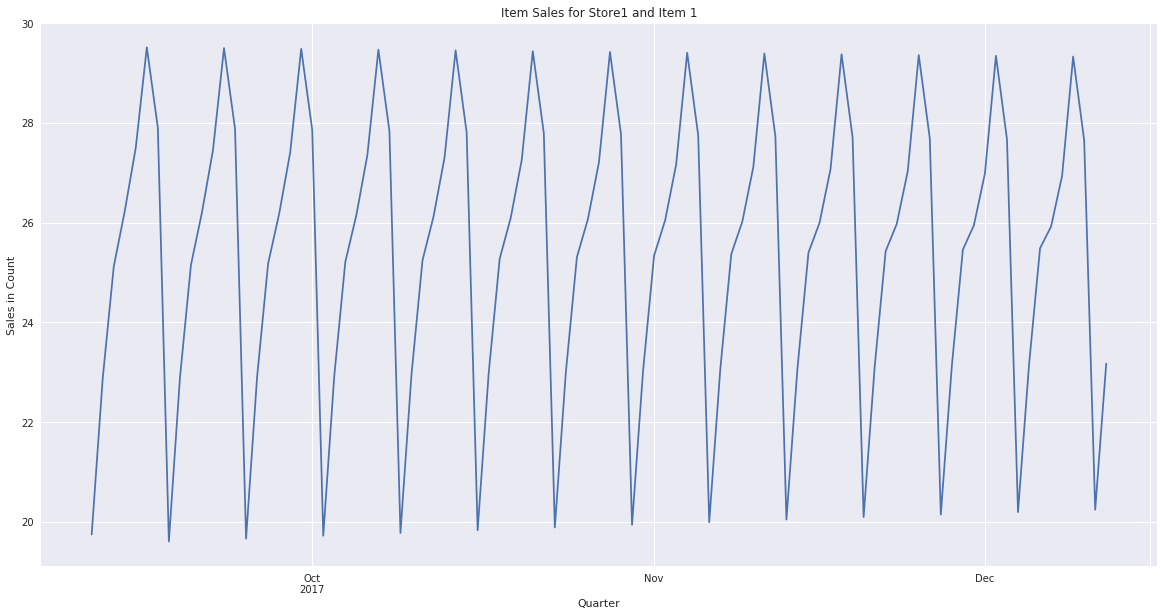